In [5]:
import torch
import torch.nn.functional as F
import matplotlib.pyplot as plt
from pytorch_generative import models as pt_gen_models

In [6]:
true_probs = torch.tensor([0.07, 0.15, 0.2, 0.05, 0.1, 0.4, 0.03])
xs = torch.arange(len(true_probs))

def plot_prob(ax, xs, prob, title):
    ax.bar(xs, prob)
    ax.set_title(title)
    ax.set_ylim(0, 1)

# Distribution Smoothening

/home/jwang/miniconda3/envs/myclone/lib/python3.7/site-packages/ipykernel_launcher.py:7: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  import sys


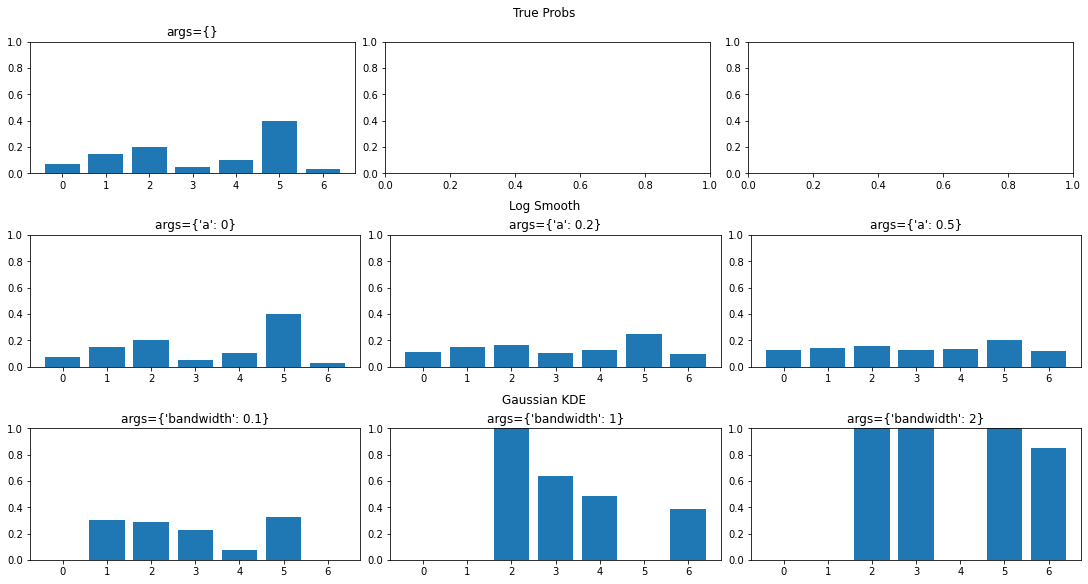

In [66]:
smooth_types = {
    "True Probs": {
        "fn": lambda probs: probs,
        "args": [{}]
    },
    "Log Smooth": {
        "fn": lambda probs, a: F.softmax(torch.log(probs+a)),
        "args": [{'a': 0}, {'a': 0.2}, {'a': 0.5}]
    },
    "Gaussian KDE": {
        "fn": lambda probs, bandwidth: pt_gen_models.KernelDensityEstimator(probs[None], pt_gen_models.GaussianKernel(bandwidth)).sample(1)[0],
        
        #pt_gen_models.KernelDensityEstimator(probs, pt_gen_models.GaussianKernel(bandwidth))(xs),
        "args": [{'bandwidth': 0.1}, {'bandwidth': 1}, {'bandwidth': 2}]
    }
}

NUM_COLS = max([len(smooth_types[smooth_type]["args"]) for smooth_type in smooth_types])

fig = plt.figure(constrained_layout=True, figsize=(15,8))
subfigs = fig.subfigures(len(smooth_types), 1)
if not hasattr(subfigs, "__len__"):
    print('kachow')
    subfigs = [subfigs]
for smooth_type, subfig in zip(smooth_types, subfigs):
    subfig.suptitle(f"{smooth_type}")
    
    axs = subfig.subplots(1, NUM_COLS)

    for i, arg in enumerate(smooth_types[smooth_type]['args']):
#         if len(smooth_types[smooth_type]['args']) <= 1:
#             import pdb; pdb.set_trace()
        plot_prob(axs[i], xs, smooth_types[smooth_type]["fn"](true_probs, **smooth_types[smooth_type]['args'][i]), f"args={smooth_types[smooth_type]['args'][i]}")

plt.show()



In [62]:
pt_gen_models.KernelDensityEstimator(true_probs[None])([1])

tensor([[ 0.0999,  0.2620,  1.5437,  1.9544, -0.9739, -0.8770, -0.5647]])

In [51]:
pt_gen_models.GaussianKernel(1)(true_probs, true_probs[None])

tensor([-4.5819])

In [60]:
xs.shape

torch.Size([7])

In [53]:
train_Xs = batch = torch.rand(4, 3)

# Test ParzenWindowKernel.
model = pt_gen_models.KernelDensityEstimator(
    kernel=pt_gen_models.ParzenWindowKernel(bandwidth=0.1), train_Xs=train_Xs
)
model(batch)
model.sample(2)

# Test GaussianKernel.
model = pt_gen_models.KernelDensityEstimator(
    kernel=pt_gen_models.GaussianKernel(bandwidth=0.1), train_Xs=train_Xs
)
model(batch)
model.sample(2)

tensor([[0.3002, 0.5243, 0.7027],
        [0.3124, 0.4933, 0.7378]])

In [54]:
model(batch)

tensor([2.7647, 2.7656, 2.7652, 2.7661])

In [55]:
train_Xs.shape

torch.Size([4, 3])

# Pytorch Gumbel Softmax matching with the paper's figure

num samples=100


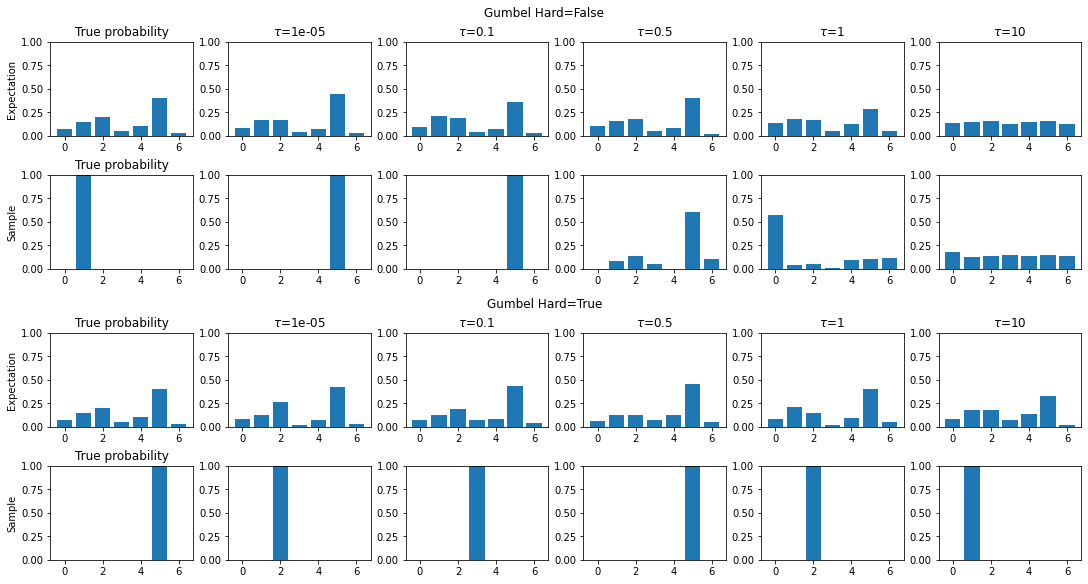

In [98]:

NUM_SAMPLES = 100
GUMBEL_TEMPS = [0.00001, 0.1, 0.5, 1, 10]
GUMBEL_HARDNESSES = [False, True]

fig = plt.figure(constrained_layout=True, figsize=(15,8))
subfigs = fig.subfigures(2, 1)
for gumbel_hardness, subfig in zip(GUMBEL_HARDNESSES, subfigs):
    subfig.suptitle(f"Gumbel Hard={gumbel_hardness}")
    
    axs = subfig.subplots(2, len(GUMBEL_TEMPS)+1)
    plot_prob(axs[0][0], xs, true_probs, "True probability")
    axs[0][0].set_ylabel(f"Expectation")
    plot_prob(axs[1][0], xs, F.one_hot(torch.distributions.categorical.Categorical(true_probs).sample(), num_classes=len(true_probs)), "True probability")
    axs[1][0].set_ylabel(f"Sample")

    for i, gumbel_temp in enumerate(GUMBEL_TEMPS):
        totals = torch.zeros_like(true_probs)
        for j in range(NUM_SAMPLES):
            inputs = torch.log(true_probs)
            sample = F.gumbel_softmax(inputs, gumbel_temp, hard=gumbel_hardness, dim=-1)
#             sample = F.gumbel_softmax(F.log_softmax(true_probs, dim=-1), gumbel_temp, hard=gumbel_hardness, eps=1e-30, dim=-1)
            if j == 0:
                plot_prob(axs[1][i+1], xs, sample, "")
            totals += sample
        totals /= NUM_SAMPLES
        plot_prob(axs[0][i+1], xs, totals, f"$\\tau$={gumbel_temp}")

print(f"num samples={NUM_SAMPLES}")
plt.show()

# Other gumbel softmax code (for hard=True only)


In [101]:
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.autograd import Variable

def sample_gumbel(shape, eps=1e-20):
    U = torch.rand(shape)
    return -Variable(torch.log(-torch.log(U + eps) + eps))

def gumbel_softmax_sample(logits, temperature):
    y = logits + sample_gumbel(logits.size())
    return F.softmax(y / temperature, dim=-1)

def github_gumbel_softmax(logits, temperature):
    """
    input: [*, n_class]
    return: [*, n_class] an one-hot vector
    """
    y = gumbel_softmax_sample(logits, temperature)
    shape = y.size()
    _, ind = y.max(dim=-1)
    y_hard = torch.zeros_like(y).view(-1, shape[-1])
    y_hard.scatter_(1, ind.view(-1, 1), 1)
    y_hard = y_hard.view(*shape)
    return (y_hard - y).detach() + y

Some GitHub gumbel softmax code I found
num samples=1000


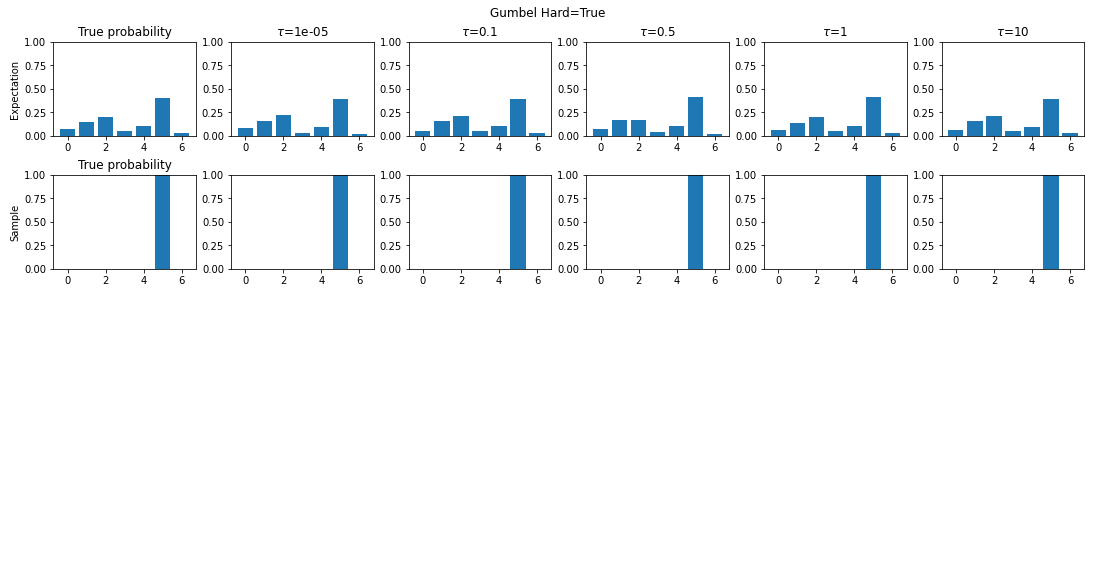

In [111]:
NUM_SAMPLES = 1000
GUMBEL_TEMPS = [0.00001, 0.1, 0.5, 1, 10]
GUMBEL_HARDNESSES = [True]

def plot_prob(ax, xs, prob, title):
    ax.bar(xs, prob)
    ax.set_title(title)
    ax.set_ylim(0, 1)

fig = plt.figure(constrained_layout=True, figsize=(15,8))
subfigs = fig.subfigures(2, 1)
for gumbel_hardness, subfig in zip(GUMBEL_HARDNESSES, subfigs):
    subfig.suptitle(f"Gumbel Hard={gumbel_hardness}")
    
    axs = subfig.subplots(2, len(GUMBEL_TEMPS)+1)
    plot_prob(axs[0][0], xs, true_probs, "True probability")
    axs[0][0].set_ylabel(f"Expectation")
    plot_prob(axs[1][0], xs, F.one_hot(torch.distributions.categorical.Categorical(true_probs).sample(), num_classes=len(true_probs)), "True probability")
    axs[1][0].set_ylabel(f"Sample")

    for i, gumbel_temp in enumerate(GUMBEL_TEMPS):
        totals = torch.zeros_like(true_probs)
        for j in range(NUM_SAMPLES):
            sample = github_gumbel_softmax(torch.log(true_probs[None]), gumbel_temp)[0]
            if j == 0:
                plot_prob(axs[1][i+1], xs, sample, "")
            totals += sample
        totals /= NUM_SAMPLES
        plot_prob(axs[0][i+1], xs, totals, f"$\\tau$={gumbel_temp}")

print("Some GitHub gumbel softmax code I found")
print(f"num samples={NUM_SAMPLES}")
plt.show()



# Pasting Pytorch's Gumbel Softmax code directly into this notebook

In [108]:
def pytorch_gumbel_softmax(logits: torch.Tensor, tau: float = 1, hard: bool = False, eps: float = 1e-10, dim: int = -1) -> torch.Tensor:
    r"""
    Samples from the Gumbel-Softmax distribution (`Link 1`_  `Link 2`_) and optionally discretizes.

    Args:
      logits: `[..., num_features]` unnormalized log probabilities
      tau: non-negative scalar temperature
      hard: if ``True``, the returned samples will be discretized as one-hot vectors,
            but will be differentiated as if it is the soft sample in autograd
      dim (int): A dimension along which softmax will be computed. Default: -1.

    Returns:
      Sampled tensor of same shape as `logits` from the Gumbel-Softmax distribution.
      If ``hard=True``, the returned samples will be one-hot, otherwise they will
      be probability distributions that sum to 1 across `dim`.

    .. note::
      This function is here for legacy reasons, may be removed from nn.Functional in the future.

    .. note::
      The main trick for `hard` is to do  `y_hard - y_soft.detach() + y_soft`

      It achieves two things:
      - makes the output value exactly one-hot
      (since we add then subtract y_soft value)
      - makes the gradient equal to y_soft gradient
      (since we strip all other gradients)

    Examples::
        >>> logits = torch.randn(20, 32)
        >>> # Sample soft categorical using reparametrization trick:
        >>> F.gumbel_softmax(logits, tau=1, hard=False)
        >>> # Sample hard categorical using "Straight-through" trick:
        >>> F.gumbel_softmax(logits, tau=1, hard=True)

    .. _Link 1:
        https://arxiv.org/abs/1611.00712
    .. _Link 2:
        https://arxiv.org/abs/1611.01144
    """
#     if has_torch_function_unary(logits):
#         print('a')
#         return handle_torch_function(gumbel_softmax, (logits,), logits, tau=tau, hard=hard, eps=eps, dim=dim)
#     if eps != 1e-10:
#         warnings.warn("`eps` parameter is deprecated and has no effect.")

    gumbels = (
        -torch.empty_like(logits, memory_format=torch.legacy_contiguous_format).exponential_().log()
    )  # ~Gumbel(0,1)
    gumbels = (logits + gumbels) / tau  # ~Gumbel(logits,tau)
    y_soft = gumbels.softmax(dim)

    if hard:
        # Straight through.
        index = y_soft.max(dim, keepdim=True)[1]
        y_hard = torch.zeros_like(logits, memory_format=torch.legacy_contiguous_format).scatter_(dim, index, 1.0)
        ret = y_hard - y_soft.detach() + y_soft
    else:
        # Reparametrization trick.
        ret = y_soft
    return ret

num samples=100


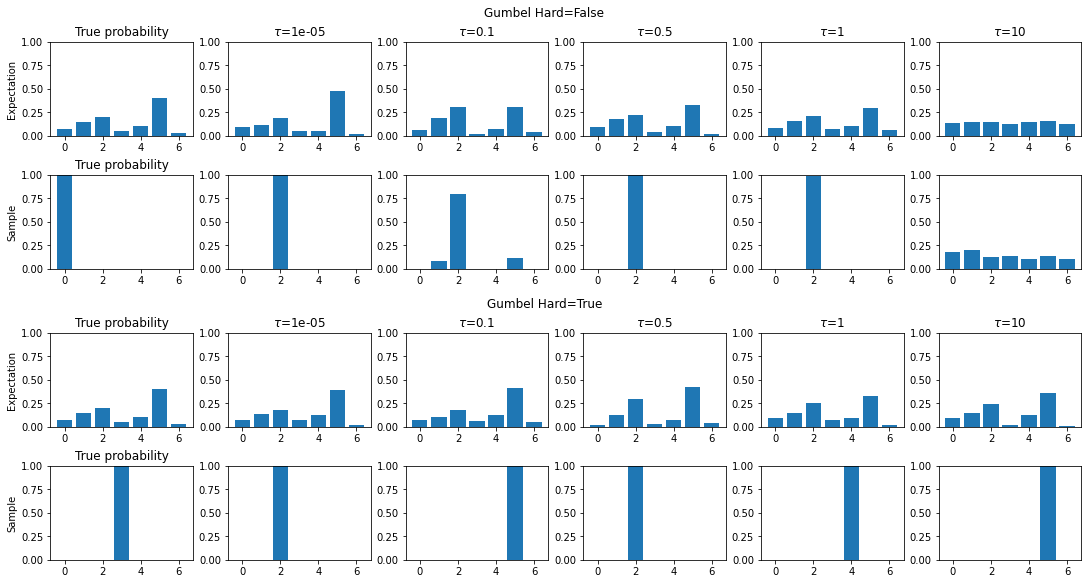

In [109]:
NUM_SAMPLES = 100
GUMBEL_TEMPS = [0.00001, 0.1, 0.5, 1, 10]
GUMBEL_HARDNESSES = [False, True]

def plot_prob(ax, xs, prob, title):
    ax.bar(xs, prob)
    ax.set_title(title)
    ax.set_ylim(0, 1)

fig = plt.figure(constrained_layout=True, figsize=(15,8))
subfigs = fig.subfigures(2, 1)
for gumbel_hardness, subfig in zip(GUMBEL_HARDNESSES, subfigs):
    subfig.suptitle(f"Gumbel Hard={gumbel_hardness}")
    
    axs = subfig.subplots(2, len(GUMBEL_TEMPS)+1)
    plot_prob(axs[0][0], xs, true_probs, "True probability")
    axs[0][0].set_ylabel(f"Expectation")
    plot_prob(axs[1][0], xs, F.one_hot(torch.distributions.categorical.Categorical(true_probs).sample(), num_classes=len(true_probs)), "True probability")
    axs[1][0].set_ylabel(f"Sample")

    for i, gumbel_temp in enumerate(GUMBEL_TEMPS):
        totals = torch.zeros_like(true_probs)
        for j in range(NUM_SAMPLES):
            inputs = torch.log(true_probs)
            sample = pytorch_gumbel_softmax(inputs, gumbel_temp, hard=gumbel_hardness, dim=-1)
#             sample = F.gumbel_softmax(F.log_softmax(true_probs, dim=-1), gumbel_temp, hard=gumbel_hardness, eps=1e-30, dim=-1)
            if j == 0:
                plot_prob(axs[1][i+1], xs, sample, "")
            totals += sample
        totals /= NUM_SAMPLES
        plot_prob(axs[0][i+1], xs, totals, f"$\\tau$={gumbel_temp}")

print(f"num samples={NUM_SAMPLES}")
plt.show()